<a href="https://colab.research.google.com/github/shobhitsundriyal/time_series/blob/master/Cryptocurrency__price__prediction_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set(style='whitegrid', palette='muted')
RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
url = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [8]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3196,2019-04-16,5212.810059,5270.759766,5190.810059,5236.259766,5236.259766,194699629
3197,2019-04-17,5236.259766,5317.779785,5232.990234,5289.750000,5289.750000,187312150
3198,2019-04-18,5289.750000,5353.009766,5212.180176,5295.529785,5295.529785,158699049
3199,2019-04-19,5295.529785,5366.600098,5274.450195,5326.180176,5326.180176,123577001
3200,2019-04-20,5326.180176,5348.589844,5232.770020,5305.740234,5305.740234,134681237


Closing Price. "Closing price" generally refers to the last price at which a stock trades during a regular trading session.</br>
So "Close" is our guy

(3201, 7)


Text(0, 0.5, 'Price(USD)')

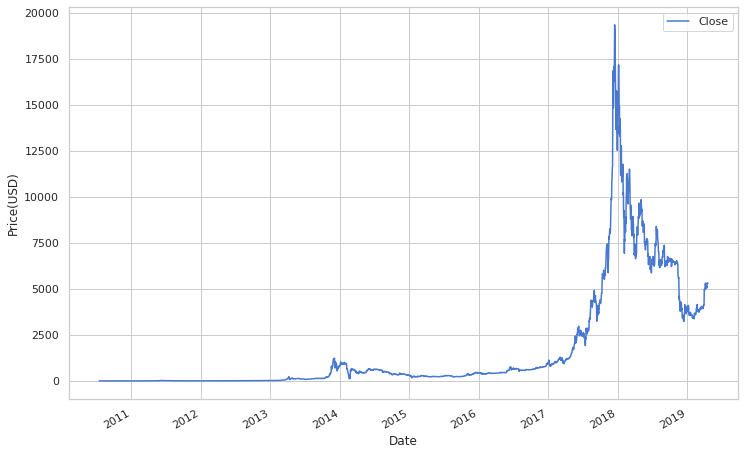

In [7]:
print(df.shape)
p = df.plot(x='Date', y='Close')
p.set_xlabel('Date')
p.set_ylabel('Price(USD)')

The freq. of this data => Daily


In [0]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scalar.fit_transform(close_price)

In [20]:
True in df.Close.isnull()

True

Ok there are some missing values so need to handle them

In [0]:
# Remove NaN values
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

---

#### Preparing Data and model Building

Lstm ip -> [batch_size, sequence_len, n_features]

In [0]:
seq_len = 100

In [0]:
def to_seq(data, seq_len):
  d = []

  for i in range(len(data) - seq_len):
    d.append(data[i: i + seq_len])
  
  d = np.array(d)
  print('Shape of data', d.shape)
  return d

def preprocess(original_data, seq_len, train_split):
  data = to_seq(original_data, seq_len)

  num_train = int(train_split * data.shape[0])

  x_train = data[:num_train, :-1, :]
  y_train = data[:num_train, -1, :]

  x_test = data[num_train:, :-1, :]
  y_test = data[num_train:, -1, :]

  return x_train, y_train, x_test, y_test

In [39]:
x_train, y_train, x_test, y_test = preprocess(scaled_close, seq_len, 0.95)

print('X_train shape = ', x_train.shape)

Shape of data (3101, 100, 1)
X_train shape =  (2945, 99, 1)


In [40]:
x_test.shape

(156, 99, 1)